*This project is for the project #1 of CIS 9660, Zicklin School of Business in Baruch College. The overall guideline and most of the codes for the process were provided by the professor.*

# Project #1: Predicting Stock Price and Bullish/Bearish

## Getting Started

A quant trading becomes popular among investment banks in recent years. Lots of individual traders are also developing their own systems when trading cryptocurrencies, stocks, or NFT. In this project, we would like to upgrade and optimize the model for analyzing stock portfolios using various machine learning algorithms.

## Dataset

The dataset includes S&P500 index with nine different macroeconomic indexes between September 2014 and the date when submitting the project to the school system. The date column does not include weekends when the market is closed. We will create a column whose name is ‘Result’ in Boolean type meaning whether the date was bullish or bearish by calculating the difference of closed prices for each consecutive two days.

- Qualitative variable: date (‘mm-dd-yyyy’), Result(Bullish/Bearish)

- Quantitative variable: CPI, Jclaim(Jobless claim), Int_rate(10 year bond rate), Stock_price(S&P500 Index), Inf(Inflation rate),
Choe(Choe volatility), Gold, Oil(Crude Oil), Bitcoin, Dollar(Dollar Index)

- Data source: https://raw.githubusercontent.com/cpasean/Projects/main/predict_aim_sourcedata_monitoring_TSLA.csv

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline 

import warnings   # ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # filter warning
warnings.filterwarnings("ignore")  # runtime warning

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/cpasean/Projects/main/predict_aim_sourcedata_monitoring_%5EGSPC.csv').reset_index(drop = True)
df

,Date,Cpi,Jclaim,Int_rate,Stock_price,Inf,Cboe,Gold,Oil,Bitcoin,Dollar
0,2014-09-17,237.477,288000.0,2.600,2001.569946,2.06,12.650000,1234.400024,94.419998,457.334015,84.699997
1,2014-09-18,237.477,288000.0,2.629,2011.359985,2.02,12.030000,1225.699951,93.070000,424.440002,84.320000
2,2014-09-19,237.477,288000.0,2.587,2010.400024,2.03,12.110000,1215.300049,92.410004,394.795990,84.800003
3,2014-09-22,237.477,295000.0,2.566,1994.290039,1.99,13.690000,1216.800049,91.519997,402.152008,84.669998
4,2014-09-23,237.477,295000.0,2.535,1982.770020,2.02,14.930000,1221.000000,91.559998,435.790985,84.660004
...,...,...,...,...,...,...,...,...,...,...,...
1926,2022-05-16,288.663,218000.0,2.877,4008.010010,2.68,27.469999,1813.500000,114.199997,29862.917969,104.190002
1927,2022-05-17,288.663,218000.0,2.968,4088.850098,2.71,26.100000,1818.199951,112.400002,30425.857422,103.360001
1928,2022-05-18,288.663,218000.0,2.886,3923.679932,2.72,30.959999,1815.900024,109.589996,28720.271484,103.809998
1929,2022-05-19,288.663,218000.0,2.855,3900.790039,2.59,29.350000,1841.199951,112.209999,30314.333984,102.720001


## Data Cleansing

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1931 entries, 0 to 1930
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1931 non-null   object 
 1   Cpi          1931 non-null   float64
 2   Jclaim       1931 non-null   float64
 3   Int_rate     1931 non-null   float64
 4   Stock_price  1931 non-null   float64
 5   Inf          1931 non-null   float64
 6   Cboe         1931 non-null   float64
 7   Gold         1931 non-null   float64
 8   Oil          1931 non-null   float64
 9   Bitcoin      1931 non-null   float64
 10  Dollar       1931 non-null   float64
dtypes: float64(10), object(1)
memory usage: 166.1+ KB


In [3]:
# convert 'Date' column into date type

df.Date = df.Date.astype('datetime64[ns]')

Number of Null values: 0


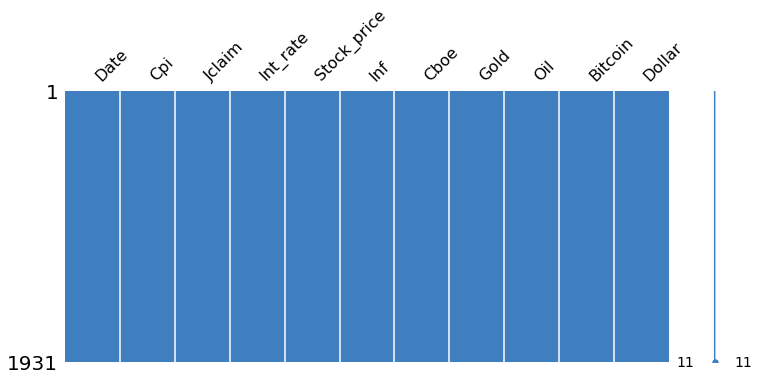

In [4]:
# check null values

import missingno as msno
msno.matrix(df, figsize = (12,5), color=(0.25, 0.5, 0.75));

print(f"Number of Null values: {df.isna().sum().sum()}")

In [5]:
# check duplicated values

print(f"Number of duplicated values: {df.duplicated().sum()}")

Number of duplicated values: 0


## Data Exploration

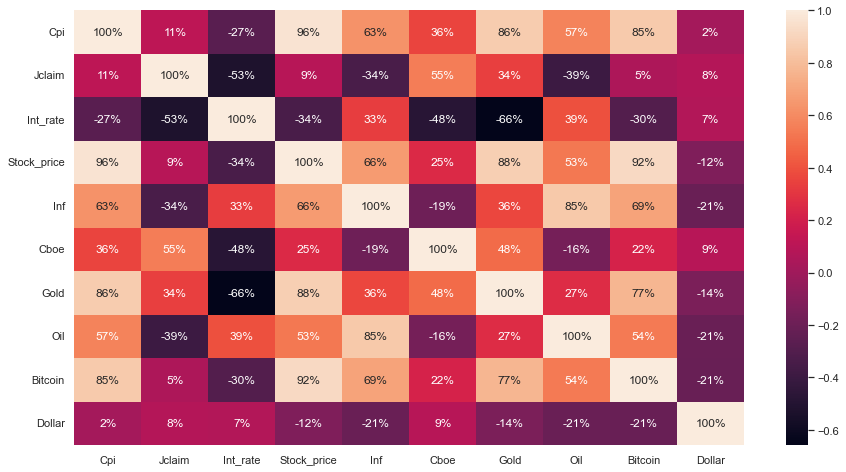

In [6]:
# Making a correlation plot

sb.set(rc = {'figure.figsize':(15,8)})
sb.heatmap(df.corr(), annot=True, fmt ='.0%');

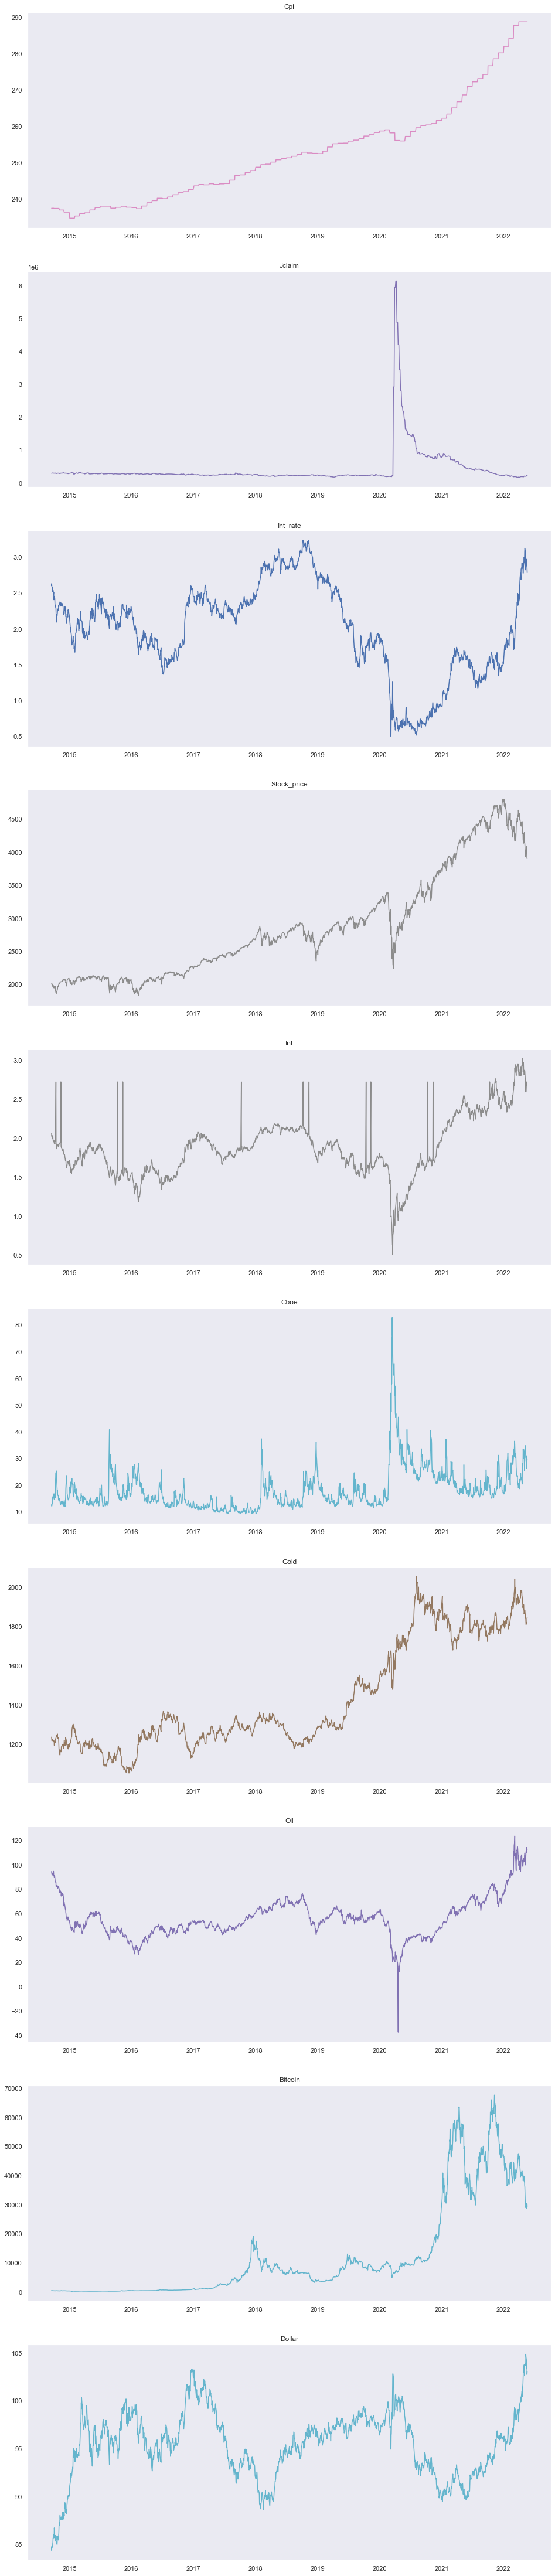

In [7]:
plt.figure(figsize = (16, 80))
c = 1
for column in df.columns[1:11].tolist():
    plt.subplot(len(df.columns[1:11].tolist()),1,c)
    c+=1
    plt.errorbar(x = df['Date'], y = df[column], label = column, color = sb.color_palette()[int(np.random.randint(10, size = 11)[0])])
    plt.title(column)
    plt.grid(axis = 'x')
    plt.grid(axis = 'y')

plt.show()

## Preprocessing the data

**Common moving average lengths are `10`, `20`, `50`, `100` and `200`.**

> *reference: https://www.investopedia.com/articles/active-trading/052014/how-use-moving-average-buy-stocks.asp*

- *Most important moving average("Why the 50-Day Simple Moving Average Is Popular Among Traders", Investopedia, J.B. MAVERICK: https://www.investopedia.com/ask/answers/012815/why-50-simple-moving-average-sma-so-common-traders-and-analysts.asp)*

In [8]:
# Get moving average

mvp = 50
i = 0

mavg = pd.DataFrame()

for column in df.columns[1:]:
    mv_change = np.array(df[column])
    mv = []
    for i in range(len(mv_change)-mvp+1):
        mv.append(np.average(mv_change[i:mvp+i]))
        i+=1
    mavg[column] = pd.DataFrame(mv)
df = mavg

In [9]:
# add a new column for the outcome, either bullish or bearish 
# if the Price change is equal to or bigger than zero, add '1' into the 'outcome' column or '0' for else case

app = []
for i in range(len(df.Stock_price)):
    if i == 0:
        app.append(0)
    else:
        if df.Stock_price[i] - df.Stock_price[i-1] >= 0:
            app.append(1)
        else:
            app.append(0)
df['Result'] = app
df.head(2)

,Cpi,Jclaim,Int_rate,Stock_price,Inf,Cboe,Gold,Oil,Bitcoin,Dollar,Result
0,237.28742,289800.0,2.35734,1983.228201,1.9594,15.7056,1205.961995,83.3586,376.032480,86.2372,0
1,237.27754,290100.0,2.35002,1984.653403,1.9546,15.6940,1205.205994,82.9440,374.253199,86.2954,1


In [10]:
# outcome 
outcomes = df.Result
outcomes

0       0
1       1
2       1
3       1
4       1
       ..
1877    0
1878    0
1879    0
1880    0
1881    0
Name: Result, Length: 1882, dtype: int64

In [11]:
# filter out unwanted columns

features = df.drop(['Result'], axis = 1)
features

,Cpi,Jclaim,Int_rate,Stock_price,Inf,Cboe,Gold,Oil,Bitcoin,Dollar
0,237.28742,289800.0,2.35734,1983.228201,1.9594,15.7056,1205.961995,83.3586,376.032480,86.2372
1,237.27754,290100.0,2.35002,1984.653403,1.9546,15.6940,1205.205994,82.9440,374.253199,86.2954
2,237.26766,290400.0,2.34132,1985.777405,1.9500,15.7200,1204.195994,82.4056,373.293339,86.3762
3,237.24316,290460.0,2.33394,1986.638203,1.9452,15.7610,1204.249993,81.9374,372.982319,86.4392
4,237.21866,290380.0,2.32832,1988.083403,1.9408,15.7442,1203.897991,81.4446,372.565579,86.5188
...,...,...,...,...,...,...,...,...,...,...
1877,288.30010,183740.0,2.58890,4324.611011,2.8550,26.3608,1922.567998,105.1656,39943.536797,100.5980
1878,288.31920,184140.0,2.61324,4322.366216,2.8538,26.1538,1919.053997,105.0256,39790.813164,100.6794
1879,288.33830,184540.0,2.63352,4317.425811,2.8502,26.0704,1914.569998,104.7434,39590.473203,100.7744
1880,288.35740,184940.0,2.65166,4309.884014,2.8452,26.0084,1911.675996,104.8136,39357.101367,100.8694


## Training the model

In [12]:
# Split data into training and testing sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size=0.3, random_state=42)

## Performing standardization

In [13]:
# Feature Scaling

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Training to Machine learning algorithms

### Logistic regression

#### Training the logistic regression

In [14]:
# Import the classifier from sklearn
from sklearn.linear_model import LogisticRegression

# Define the classifier, and fit it to the data
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

#### Testing the model

In [15]:
# Making predictions
y_train_pred_lr = model.predict(X_train)
y_test_pred_lr = model.predict(X_test)

# Calculate the accuracy
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, y_train_pred_lr)
test_accuracy = accuracy_score(y_test, y_test_pred_lr)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 0.85041761579347
The test accuracy is 0.8336283185840708


In [16]:
# Getting the Parameters of the Decision Tree

model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

#### 5-Fold cross validation

In [17]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

k = 5
kf = KFold(n_splits=k)

#for other scoring parameters see here https://scikit-learn.org/stable/modules/model_evaluation.html
result = cross_val_score(model, X_train, y_train.ravel(), cv = kf, scoring='accuracy')
 
print(f' Avg accuracy:{result.mean()}')

 Avg accuracy:0.8488708376541076


#### Stratified 10-Fold Cross Validation

In [18]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=32)
result = cross_val_score(model, X_train, y_train.ravel(), cv = skf, scoring='accuracy')
print(f' Avg accuracy:{result.mean()}')

 Avg accuracy:0.8481263011797363


> the score is less than the full set for train, but it's within the acceptable range of 2~5%  

#### Generating the confusion matrix

In [19]:
#Generating the confusion matrix using scikit-learn's confusion matrix method
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_test_pred_lr)

array([[ 98,  72],
       [ 22, 373]], dtype=int64)

In [20]:
#Generating the confusion matrix as a dataframe. 
pd.DataFrame(confusion_matrix(y_test, y_test_pred_lr), columns = ['Actual Positive (Up)', 'Acutal Negative (Down)'], index = [ 'Predicted Positive (Up)', 'Predicted Negative (Down)']          )

,Actual Positive (Up),Acutal Negative (Down)
Predicted Positive (Up),98,72
Predicted Negative (Down),22,373


#### Classification Report

In [21]:
#Generate Classification Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred_lr))

              precision    recall  f1-score   support

           0       0.82      0.58      0.68       170
           1       0.84      0.94      0.89       395

    accuracy                           0.83       565
   macro avg       0.83      0.76      0.78       565
weighted avg       0.83      0.83      0.82       565



In [22]:
report =  classification_report(y_test, y_test_pred_lr)
lines = report.split('\n')

score = {}
score['model'] = 'Logistic Regression' 
for i in range(len(lines[5:-1])):
#     print(lines[5:-1][i].split('      '))
    if i == 0:
        score['accuracy'] = float(lines[5:-1][i].split('      ')[4].strip())*100
    elif i == 2:
        score['precision'] = float(lines[5:-1][i].split('      ')[1].strip())*100
        score['recall'] = float(lines[5:-1][i].split('      ')[2].strip())*100
        score['f1-score'] = float(lines[5:-1][i].split('      ')[3].strip())*100
        score['support'] = float(lines[5:-1][i].split('      ')[4].strip())

score_lr_df = pd.DataFrame([score])
score_lr_df

,model,accuracy,precision,recall,f1-score,support
0,Logistic Regression,83.0,83.0,83.0,82.0,565.0


#### Converting the prediction to a dataframe

In [23]:
#converting the prediction to a dataframe

y_pred_df = pd.DataFrame(y_test_pred_lr, columns = ['predicted price up or down'])

In [24]:
#dataframe of predicted values
y_pred_df.head(2)

,predicted price up or down
0,1
1,1


In [25]:
# creating a merged dataframe of test data and the predictions

df = pd.concat([pd.DataFrame(X_test, columns = features.columns).reset_index(drop=True), y_test.reset_index(drop=True), y_pred_df.reset_index(drop=True)], axis=1)

In [26]:
# We can now compare our predictions with the actual data

df.head()

,Cpi,Jclaim,Int_rate,Stock_price,Inf,Cboe,Gold,Oil,Bitcoin,Dollar,Result,predicted price up or down
0,0.679896,0.677642,-1.773689,0.849355,-0.240178,1.299619,1.714555,-0.991116,0.188251,-0.901483,1,1
1,0.398699,-0.392942,-0.354657,0.183303,-0.658690,-0.487642,0.259255,0.029440,-0.184783,0.968678,1,1
2,-0.309394,-0.361942,0.806427,-0.195908,0.263566,-1.155803,-0.490673,0.359650,0.073058,-1.028698,1,1
3,-0.408370,-0.343206,0.601139,-0.380992,0.041378,-1.216180,-0.546160,-0.119649,-0.364314,-0.552205,1,1
4,-0.524726,-0.330410,0.399333,-0.499776,-0.191390,-1.086348,-0.522742,-0.490787,-0.514079,-0.772879,1,1


### Decision Tree

#### Training the Decision Tree Classifier

In [27]:
# Import the classifier from sklearn
from sklearn.tree import DecisionTreeClassifier

# Define the classifier, and fit it to the data
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

#### Testing the model

In [28]:
# Making predictions
y_train_pred_dt = model.predict(X_train)
y_test_pred_dt = model.predict(X_test)

# Calculate the accuracy
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, y_train_pred_dt)
test_accuracy = accuracy_score(y_test, y_test_pred_dt)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 1.0
The test accuracy is 0.9610619469026549


In [29]:
# Getting the Parameters of the Decision Tree

model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

> `high training accuracy` and a `lower testing accuracy`. This may be **overfitting** a bit.

Improve the test accuracy by adjusting each parameter

- `max_depth`
- `min_samples_leaf`
- `min_samples_split`

reference - https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html


In [30]:
model = DecisionTreeClassifier(max_depth = 13, min_samples_leaf = 1, min_samples_split = 2)
model.fit(X_train, y_train)

y_train_pred_dt = model.predict(X_train)
y_test_pred_dt = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred_dt)
test_accuracy = accuracy_score(y_test, y_test_pred_dt)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 0.996962794229309
The test accuracy is 0.95929203539823


#### 5-Fold cross validation

In [31]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

k = 5
kf = KFold(n_splits=k)

#for other scoring parameters see here https://scikit-learn.org/stable/modules/model_evaluation.html
result = cross_val_score(model, X_train, y_train.ravel(), cv = kf, scoring='accuracy')
 
print(f' Avg accuracy:{result.mean()}')

 Avg accuracy:0.9270998963014172


#### Stratified 10-Fold Cross Validation

In [32]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=32)
result = cross_val_score(model, X_train, y_train.ravel(), cv = skf, scoring='accuracy')
print(f' Avg accuracy:{result.mean()}')

 Avg accuracy:0.939266712930835


> the score is less than the full set for train, but it's within the acceptable range of 2~5%  

#### Generating the confusion matrix

In [33]:
#Generating the confusion matrix using scikit-learn's confusion matrix method
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_test_pred_dt)

array([[154,  16],
       [  7, 388]], dtype=int64)

In [34]:
#Generating the confusion matrix as a dataframe. 
pd.DataFrame(confusion_matrix(y_test, y_test_pred_dt), columns = ['Actual Positive (Up)', 'Acutal Negative (Down)'], index = [ 'Predicted Positive (Up)', 'Predicted Negative (Down)']          )

,Actual Positive (Up),Acutal Negative (Down)
Predicted Positive (Up),154,16
Predicted Negative (Down),7,388


#### Classification Report

In [35]:
#Generate Classification Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred_dt))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       170
           1       0.96      0.98      0.97       395

    accuracy                           0.96       565
   macro avg       0.96      0.94      0.95       565
weighted avg       0.96      0.96      0.96       565



In [36]:
report =  classification_report(y_test, y_test_pred_dt)
lines = report.split('\n')

score = {}
score['model'] = 'Decision Tree'
for i in range(len(lines[5:-1])):
#     print(lines[5:-1][i].split('      '))
    if i == 0:
        score['accuracy'] = float(lines[5:-1][i].split('      ')[4].strip())*100
    elif i == 2:
        score['precision'] = float(lines[5:-1][i].split('      ')[1].strip())*100
        score['recall'] = float(lines[5:-1][i].split('      ')[2].strip())*100
        score['f1-score'] = float(lines[5:-1][i].split('      ')[3].strip())*100
        score['support'] = float(lines[5:-1][i].split('      ')[4].strip())

score_dt_df = pd.DataFrame([score])
score_dt_df

,model,accuracy,precision,recall,f1-score,support
0,Decision Tree,96.0,96.0,96.0,96.0,565.0


#### Converting the prediction to a dataframe

In [37]:
#converting the prediction to a dataframe

y_pred_df = pd.DataFrame(y_test_pred_dt, columns = ['predicted price up or down'])

In [38]:
#dataframe of predicted values
y_pred_df.head(2)

,predicted price up or down
0,1
1,1


In [39]:
# creating a merged dataframe of test data and the predictions

df = pd.concat([pd.DataFrame(X_test, columns = features.columns).reset_index(drop=True), y_test.reset_index(drop=True), y_pred_df.reset_index(drop=True)], axis=1)

In [40]:
# We can now compare our predictions with the actual data

df.head()

,Cpi,Jclaim,Int_rate,Stock_price,Inf,Cboe,Gold,Oil,Bitcoin,Dollar,Result,predicted price up or down
0,0.679896,0.677642,-1.773689,0.849355,-0.240178,1.299619,1.714555,-0.991116,0.188251,-0.901483,1,1
1,0.398699,-0.392942,-0.354657,0.183303,-0.658690,-0.487642,0.259255,0.029440,-0.184783,0.968678,1,1
2,-0.309394,-0.361942,0.806427,-0.195908,0.263566,-1.155803,-0.490673,0.359650,0.073058,-1.028698,1,1
3,-0.408370,-0.343206,0.601139,-0.380992,0.041378,-1.216180,-0.546160,-0.119649,-0.364314,-0.552205,1,1
4,-0.524726,-0.330410,0.399333,-0.499776,-0.191390,-1.086348,-0.522742,-0.490787,-0.514079,-0.772879,1,1


### Random Forest 

#### Training the Random Forest Classifier

In [41]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=10, criterion='gini',random_state=1)
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(n_estimators=10, random_state=1)

#### Testing the model

In [42]:
y_train_pred_rf = model.predict(X_train)
y_test_pred_rf = model.predict(X_test)

# Calculate the accuracy
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, y_train_pred_rf)
test_accuracy = accuracy_score(y_test, y_test_pred_rf)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 0.9954441913439636
The test accuracy is 0.952212389380531


> `high training accuracy` and a `lower testing accuracy`, so adjust the parameter to get the higher test accuracy

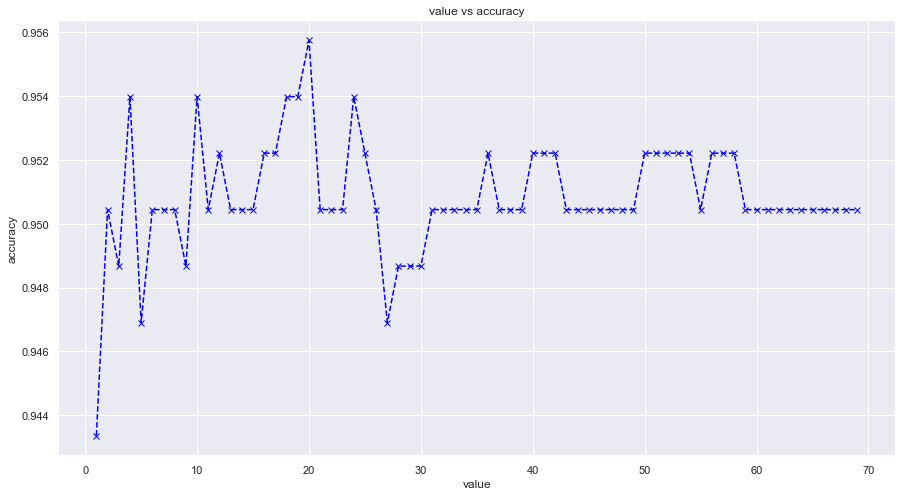

In [43]:
# find the highest parameter

from sklearn.metrics import accuracy_score
accuracy = []

for i in range(1,70):
  rf = RandomForestClassifier(n_estimators=i, criterion='gini',random_state=8)
  rf.fit(X_train, y_train.ravel())
  y_pred = rf.predict(X_test)
  accuracy.append(accuracy_score(y_test, y_pred.ravel()))
plt.plot(list(range(1,70)), accuracy, color='blue', linestyle='dashed', marker='x')
plt.xlabel('value')
plt.ylabel('accuracy')
plt.title('value vs accuracy')
plt.show()

In [44]:
df = pd.DataFrame(accuracy, list(range(1,70)), columns = ['Accruacy'])
df[df['Accruacy'] == df['Accruacy'].max()]

,Accruacy
20,0.955752


In [45]:
# Retrain the model according to the highest parameter

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=df[df['Accruacy'] == df['Accruacy'].max()].index.values[0], criterion='gini',random_state=8)
rf.fit(X_train, y_train.values.ravel())

y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

# Calculate the accuracy
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, y_train_pred_rf)
test_accuracy = accuracy_score(y_test, y_test_pred_rf)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 0.996962794229309
The test accuracy is 0.9557522123893806


#### 5-Fold cross validation

In [46]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

k = 5
kf = KFold(n_splits=k)

#for other scoring parameters see here https://scikit-learn.org/stable/modules/model_evaluation.html
result = cross_val_score(model, X_train, y_train.ravel(), cv = kf, scoring='accuracy')
 
print(f' Avg accuracy:{result.mean()}')

 Avg accuracy:0.9422802166148173


#### Stratified 10-Fold Cross Validation

In [47]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=32)
result = cross_val_score(model, X_train, y_train.ravel(), cv = skf, scoring='accuracy')
print(f' Avg accuracy:{result.mean()}')

 Avg accuracy:0.9400185056673607


> the score is less than the full set for train, but it's within the acceptable range of 2~5%  

#### Generating the confusion matrix

In [48]:
confusion_matrix(y_test, y_test_pred_rf)

array([[153,  17],
       [  8, 387]], dtype=int64)

In [49]:
#Generating the confusion matrix as a dataframe. 
pd.DataFrame(confusion_matrix(y_test, y_test_pred_rf), columns = ['Actual Positive (Up)', 'Acutal Negative (Down)'], index = [ 'Predicted Positive (Up)', 'Predicted Negative (Down)']          )

,Actual Positive (Up),Acutal Negative (Down)
Predicted Positive (Up),153,17
Predicted Negative (Down),8,387


#### Classification Report

In [50]:
#Generate Classification Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred_rf))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92       170
           1       0.96      0.98      0.97       395

    accuracy                           0.96       565
   macro avg       0.95      0.94      0.95       565
weighted avg       0.96      0.96      0.96       565



In [51]:
report =  classification_report(y_test, y_test_pred_rf)
lines = report.split('\n')

score = {}
score['model'] = 'Random Forest'
for i in range(len(lines[5:-1])):
#     print(lines[5:-1][i].split('      '))
    if i == 0:
        score['accuracy'] = float(lines[5:-1][i].split('      ')[4].strip())*100
    elif i == 2:
        score['precision'] = float(lines[5:-1][i].split('      ')[1].strip())*100
        score['recall'] = float(lines[5:-1][i].split('      ')[2].strip())*100
        score['f1-score'] = float(lines[5:-1][i].split('      ')[3].strip())*100
        score['support'] = float(lines[5:-1][i].split('      ')[4].strip())

score_rf_df = pd.DataFrame([score])
score_rf_df

,model,accuracy,precision,recall,f1-score,support
0,Random Forest,96.0,96.0,96.0,96.0,565.0


#### Converting the prediction to a dataframe

In [52]:
#converting the prediction to a dataframe

y_pred_df = pd.DataFrame(y_test_pred_rf, columns = ['predicted price up or down'])

In [53]:
#dataframe of predicted values
y_pred_df.head(2)

,predicted price up or down
0,1
1,1


In [54]:
# creating a merged dataframe of test data and the predictions

df = pd.concat([pd.DataFrame(X_test, columns = features.columns).reset_index(drop=True), y_test.reset_index(drop=True), y_pred_df.reset_index(drop=True)], axis=1)

In [55]:
# We can now compare our predictions with the actual data

df.head()

,Cpi,Jclaim,Int_rate,Stock_price,Inf,Cboe,Gold,Oil,Bitcoin,Dollar,Result,predicted price up or down
0,0.679896,0.677642,-1.773689,0.849355,-0.240178,1.299619,1.714555,-0.991116,0.188251,-0.901483,1,1
1,0.398699,-0.392942,-0.354657,0.183303,-0.658690,-0.487642,0.259255,0.029440,-0.184783,0.968678,1,1
2,-0.309394,-0.361942,0.806427,-0.195908,0.263566,-1.155803,-0.490673,0.359650,0.073058,-1.028698,1,1
3,-0.408370,-0.343206,0.601139,-0.380992,0.041378,-1.216180,-0.546160,-0.119649,-0.364314,-0.552205,1,1
4,-0.524726,-0.330410,0.399333,-0.499776,-0.191390,-1.086348,-0.522742,-0.490787,-0.514079,-0.772879,1,1


### MNB(Multinomial Naive Bayes)

#### Training the Naiver Bayes

In [56]:
from sklearn.naive_bayes import MultinomialNB

#We are using a Multinomial naive_bayes classifier hence we chose the Multinomial model. 
#Because the model requires to have positive inputs we get the original dataset before standardization
#For a list of other distributions, see here: https://scikit-learn.org/stable/modules/naive_bayes.html

X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size=0.3, random_state=42)
model = MultinomialNB()
model.fit(X_train, y_train.ravel())

MultinomialNB()

#### Testing the model

In [57]:
y_train_pred_mnb = model.predict(X_train)
y_test_pred_mnb = model.predict(X_test)

# Calculate the accuracy
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, y_train_pred_mnb)
test_accuracy = accuracy_score(y_test, y_test_pred_mnb)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 0.4274867122247532
The test accuracy is 0.39469026548672564


#### 5-Fold cross validation

In [58]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

k = 5
kf = KFold(n_splits=k)

#for other scoring parameters see here https://scikit-learn.org/stable/modules/model_evaluation.html
result = cross_val_score(model, X_train, y_train.ravel(), cv = kf, scoring='accuracy')
 
print(f' Avg accuracy:{result.mean()}')

 Avg accuracy:0.40392902408111536


#### Stratified 10-Fold Cross Validation

In [59]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=32)
result = cross_val_score(model, X_train, y_train.ravel(), cv = skf, scoring='accuracy')
print(f' Avg accuracy:{result.mean()}')

 Avg accuracy:0.40617626648161


> the score is less than the full set for train, but it's within the acceptable range of 2~5%  

#### Generating the confusion matrix

In [60]:
confusion_matrix(y_test, y_test_pred_mnb)

array([[114,  56],
       [286, 109]], dtype=int64)

In [61]:
#Generating the confusion matrix as a dataframe. 
pd.DataFrame(confusion_matrix(y_test, y_test_pred_mnb), columns = ['Actual Positive (Up)', 'Acutal Negative (Down)'], index = [ 'Predicted Positive (Up)', 'Predicted Negative (Down)']          )

,Actual Positive (Up),Acutal Negative (Down)
Predicted Positive (Up),114,56
Predicted Negative (Down),286,109


#### Classification Report

In [62]:
#Generate Classification Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred_mnb))

              precision    recall  f1-score   support

           0       0.28      0.67      0.40       170
           1       0.66      0.28      0.39       395

    accuracy                           0.39       565
   macro avg       0.47      0.47      0.39       565
weighted avg       0.55      0.39      0.39       565



In [63]:
report =  classification_report(y_test, y_test_pred_mnb)
lines = report.split('\n')

score = {}
score['model'] = 'Multinomial Naive Bayes'
for i in range(len(lines[5:-1])):
#     print(lines[5:-1][i].split('      '))
    if i == 0:
        score['accuracy'] = float(lines[5:-1][i].split('      ')[4].strip())*100
    elif i == 2:
        score['precision'] = float(lines[5:-1][i].split('      ')[1].strip())*100
        score['recall'] = float(lines[5:-1][i].split('      ')[2].strip())*100
        score['f1-score'] = float(lines[5:-1][i].split('      ')[3].strip())*100
        score['support'] = float(lines[5:-1][i].split('      ')[4].strip())

score_mnb_df = pd.DataFrame([score])
score_mnb_df

,model,accuracy,precision,recall,f1-score,support
0,Multinomial Naive Bayes,39.0,55.0,39.0,39.0,565.0


#### Converting the prediction to a dataframe

In [64]:
#converting the prediction to a dataframe

y_pred_df = pd.DataFrame(y_test_pred_mnb, columns = ['predicted price up or down'])

In [65]:
#dataframe of predicted values
y_pred_df.head(2)

,predicted price up or down
0,1
1,0


In [66]:
# creating a merged dataframe of test data and the predictions

df = pd.concat([pd.DataFrame(X_test, columns = features.columns).reset_index(drop=True), y_test.reset_index(drop=True), y_pred_df.reset_index(drop=True)], axis=1)

In [67]:
# We can now compare our predictions with the actual data

df.head()

,Cpi,Jclaim,Int_rate,Stock_price,Inf,Cboe,Gold,Oil,Bitcoin,Dollar,Result,predicted price up or down
0,260.71776,785540.0,0.84210,3518.126792,1.7792,26.2990,1875.433999,41.4074,15059.927520,92.6416,1,1
1,257.13670,223300.0,1.73836,3000.666597,1.6368,14.8788,1493.611990,55.6552,8995.826162,98.2926,1,0
2,248.11910,239580.0,2.47170,2706.055415,1.9506,10.6094,1296.856001,60.2652,13187.328574,92.2572,1,0
3,246.85864,249420.0,2.34204,2562.262012,1.8750,10.2236,1282.298003,53.5738,6077.344575,93.6970,1,0
4,245.37684,256140.0,2.21458,2469.978223,1.7958,11.0532,1288.441997,48.3924,3642.751797,93.0302,1,0


### GNB(Gaussian Naive Bayes)

#### Training the Naiver Bayes

In [68]:
# Feature Scaling

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [69]:
from sklearn.naive_bayes import GaussianNB

#We are using a Gaussian distribution for the Naive Bayes classifier hence we chose the GaussianNB model. 
#For a list of other distributions, see here: https://scikit-learn.org/stable/modules/naive_bayes.html
model = GaussianNB()
model.fit(X_train, y_train.ravel())

GaussianNB()

#### Testing the model

In [70]:
y_train_pred_gnb = model.predict(X_train)
y_test_pred_gnb = model.predict(X_test)

# Calculate the accuracy
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, y_train_pred_gnb)
test_accuracy = accuracy_score(y_test, y_test_pred_gnb)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 0.7760060744115413
The test accuracy is 0.7805309734513274


#### 5-Fold cross validation

In [71]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

k = 5
kf = KFold(n_splits=k)

#for other scoring parameters see here https://scikit-learn.org/stable/modules/model_evaluation.html
result = cross_val_score(model, X_train, y_train.ravel(), cv = kf, scoring='accuracy')
 
print(f' Avg accuracy:{result.mean()}')

 Avg accuracy:0.7760139416983524


#### Stratified 10-Fold Cross Validation

In [72]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=32)
result = cross_val_score(model, X_train, y_train.ravel(), cv = skf, scoring='accuracy')
print(f' Avg accuracy:{result.mean()}')

 Avg accuracy:0.7745431413370344


> the score is less than the full set for train, but it's within the acceptable range of 2~5%  

#### Generating the confusion matrix

In [73]:
confusion_matrix(y_test, y_test_pred_gnb)

array([[ 57, 113],
       [ 11, 384]], dtype=int64)

In [74]:
#Generating the confusion matrix as a dataframe. 
pd.DataFrame(confusion_matrix(y_test, y_test_pred_gnb), columns = ['Actual Positive (Up)', 'Acutal Negative (Down)'], index = [ 'Predicted Positive (Up)', 'Predicted Negative (Down)']          )

,Actual Positive (Up),Acutal Negative (Down)
Predicted Positive (Up),57,113
Predicted Negative (Down),11,384


#### Classification Report

In [75]:
#Generate Classification Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred_gnb))

              precision    recall  f1-score   support

           0       0.84      0.34      0.48       170
           1       0.77      0.97      0.86       395

    accuracy                           0.78       565
   macro avg       0.81      0.65      0.67       565
weighted avg       0.79      0.78      0.75       565



In [76]:
report =  classification_report(y_test, y_test_pred_gnb)
lines = report.split('\n')

score = {}
score['model'] = 'Guassian Naive Bayes'
for i in range(len(lines[5:-1])):
#     print(lines[5:-1][i].split('      '))
    if i == 0:
        score['accuracy'] = float(lines[5:-1][i].split('      ')[4].strip())*100
    elif i == 2:
        score['precision'] = float(lines[5:-1][i].split('      ')[1].strip())*100
        score['recall'] = float(lines[5:-1][i].split('      ')[2].strip())*100
        score['f1-score'] = float(lines[5:-1][i].split('      ')[3].strip())*100
        score['support'] = float(lines[5:-1][i].split('      ')[4].strip())

score_gnb_df = pd.DataFrame([score])
score_gnb_df

,model,accuracy,precision,recall,f1-score,support
0,Guassian Naive Bayes,78.0,79.0,78.0,75.0,565.0


#### Converting the prediction to a dataframe

In [77]:
#converting the prediction to a dataframe

y_pred_df = pd.DataFrame(y_test_pred_gnb, columns = ['predicted price up or down'])

In [78]:
#dataframe of predicted values
y_pred_df.head(2)

,predicted price up or down
0,1
1,1


In [79]:
# creating a merged dataframe of test data and the predictions

df = pd.concat([pd.DataFrame(X_test, columns = features.columns).reset_index(drop=True), y_test.reset_index(drop=True), y_pred_df.reset_index(drop=True)], axis=1)

In [80]:
# We can now compare our predictions with the actual data

df.head()

,Cpi,Jclaim,Int_rate,Stock_price,Inf,Cboe,Gold,Oil,Bitcoin,Dollar,Result,predicted price up or down
0,0.679896,0.677642,-1.773689,0.849355,-0.240178,1.299619,1.714555,-0.991116,0.188251,-0.901483,1,1
1,0.398699,-0.392942,-0.354657,0.183303,-0.658690,-0.487642,0.259255,0.029440,-0.184783,0.968678,1,1
2,-0.309394,-0.361942,0.806427,-0.195908,0.263566,-1.155803,-0.490673,0.359650,0.073058,-1.028698,1,1
3,-0.408370,-0.343206,0.601139,-0.380992,0.041378,-1.216180,-0.546160,-0.119649,-0.364314,-0.552205,1,1
4,-0.524726,-0.330410,0.399333,-0.499776,-0.191390,-1.086348,-0.522742,-0.490787,-0.514079,-0.772879,1,1


### KNN(K-Nearest Neighbors)

#### Training the KNN

In [81]:
from sklearn.neighbors import KNeighborsClassifier

#Note: here we are calling our KNN model knn. In the titantic example, we called our model lr. This is your choice. 
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train.ravel())

KNeighborsClassifier()

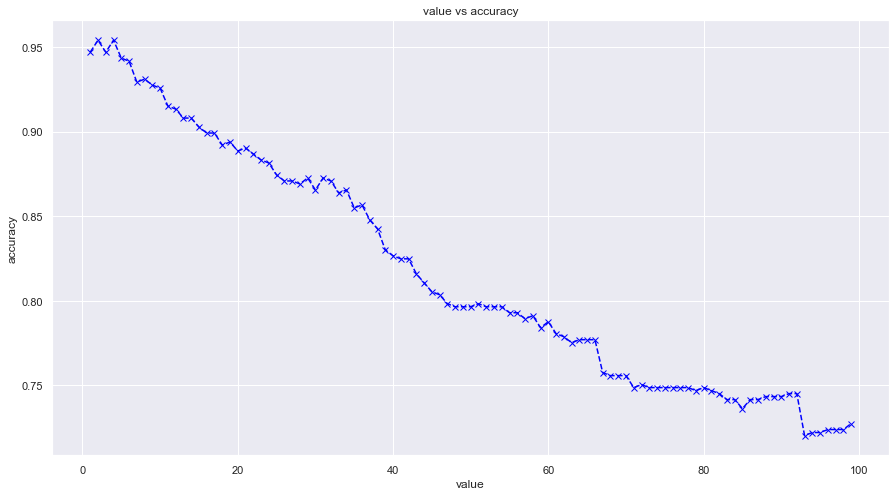

In [82]:
# find the highest parameter

from sklearn.metrics import accuracy_score
accuracy = []

for i in range(1,100):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train, y_train.ravel())
  y_pred = knn.predict(X_test)
  accuracy.append(accuracy_score(y_test, y_pred.ravel()))
plt.plot(list(range(1,100)), accuracy, color='blue', linestyle='dashed', marker='x')
plt.xlabel('value')
plt.ylabel('accuracy')
plt.title('value vs accuracy')
plt.show()

In [83]:
df = pd.DataFrame(accuracy, list(range(1,100)), columns = ['Accruacy'])
df[df['Accruacy'] == df['Accruacy'].max()]

,Accruacy
2,0.953982
4,0.953982


In [84]:
# Retrain the model according to the highest parameter

from sklearn.neighbors import KNeighborsClassifier

#Note: here we are calling our KNN model knn. In the titantic example, we called our model lr. This is your choice. 
model = KNeighborsClassifier(n_neighbors=df[df['Accruacy'] == df['Accruacy'].max()].index.values[0])
model.fit(X_train, y_train.ravel())

KNeighborsClassifier(n_neighbors=2)

#### Testing the model

In [85]:
y_train_pred_knn = model.predict(X_train)
y_test_pred_knn = model.predict(X_test)

# Calculate the accuracy
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, y_train_pred_knn)
test_accuracy = accuracy_score(y_test, y_test_pred_knn)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 0.9719058466211086
The test accuracy is 0.9539823008849557


#### 5-Fold cross validation

In [86]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

k = 5
kf = KFold(n_splits=k)

#for other scoring parameters see here https://scikit-learn.org/stable/modules/model_evaluation.html
result = cross_val_score(model, X_train, y_train.ravel(), cv = kf, scoring='accuracy')
 
print(f' Avg accuracy:{result.mean()}')

 Avg accuracy:0.9308820140569191


#### Stratified 10-Fold Cross Validation

In [87]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=32)
result = cross_val_score(model, X_train, y_train.ravel(), cv = skf, scoring='accuracy')
print(f' Avg accuracy:{result.mean()}')

 Avg accuracy:0.9256014341892206


> the score is less than the full set for train, but it's within the acceptable range of 2~5%  

#### Generating the confusion matrix

In [88]:
confusion_matrix(y_test, y_test_pred_knn)

array([[164,   6],
       [ 20, 375]], dtype=int64)

In [89]:
#Generating the confusion matrix as a dataframe. 
pd.DataFrame(confusion_matrix(y_test, y_test_pred_knn), columns = ['Actual Positive (Up)', 'Acutal Negative (Down)'], index = [ 'Predicted Positive (Up)', 'Predicted Negative (Down)']          )

,Actual Positive (Up),Acutal Negative (Down)
Predicted Positive (Up),164,6
Predicted Negative (Down),20,375


#### Classification Report

In [90]:
#Generate Classification Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred_knn))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       170
           1       0.98      0.95      0.97       395

    accuracy                           0.95       565
   macro avg       0.94      0.96      0.95       565
weighted avg       0.96      0.95      0.95       565



In [91]:
report =  classification_report(y_test, y_test_pred_knn)
lines = report.split('\n')

score = {}
score['model'] = 'K-Nearest Neighbors'
for i in range(len(lines[5:-1])):
#     print(lines[5:-1][i].split('      '))
    if i == 0:
        score['accuracy'] = float(lines[5:-1][i].split('      ')[4].strip())*100
    elif i == 2:
        score['precision'] = float(lines[5:-1][i].split('      ')[1].strip())*100
        score['recall'] = float(lines[5:-1][i].split('      ')[2].strip())*100
        score['f1-score'] = float(lines[5:-1][i].split('      ')[3].strip())*100
        score['support'] = float(lines[5:-1][i].split('      ')[4].strip())

score_knn_df = pd.DataFrame([score])
score_knn_df

,model,accuracy,precision,recall,f1-score,support
0,K-Nearest Neighbors,95.0,96.0,95.0,95.0,565.0


#### Converting the prediction to a dataframe

In [92]:
#converting the prediction to a dataframe

y_pred_df = pd.DataFrame(y_test_pred_knn, columns = ['predicted price up or down'])

In [93]:
#dataframe of predicted values
y_pred_df.head(2)

,predicted price up or down
0,1
1,1


In [94]:
# creating a merged dataframe of test data and the predictions

df = pd.concat([pd.DataFrame(X_test, columns = features.columns).reset_index(drop=True), y_test.reset_index(drop=True), y_pred_df.reset_index(drop=True)], axis=1)

In [95]:
# We can now compare our predictions with the actual data

df.head()

,Cpi,Jclaim,Int_rate,Stock_price,Inf,Cboe,Gold,Oil,Bitcoin,Dollar,Result,predicted price up or down
0,0.679896,0.677642,-1.773689,0.849355,-0.240178,1.299619,1.714555,-0.991116,0.188251,-0.901483,1,1
1,0.398699,-0.392942,-0.354657,0.183303,-0.658690,-0.487642,0.259255,0.029440,-0.184783,0.968678,1,1
2,-0.309394,-0.361942,0.806427,-0.195908,0.263566,-1.155803,-0.490673,0.359650,0.073058,-1.028698,1,1
3,-0.408370,-0.343206,0.601139,-0.380992,0.041378,-1.216180,-0.546160,-0.119649,-0.364314,-0.552205,1,1
4,-0.524726,-0.330410,0.399333,-0.499776,-0.191390,-1.086348,-0.522742,-0.490787,-0.514079,-0.772879,1,1


### SVM(Support Vector Machines by Linear)

#### Training the SVM

In [96]:
from sklearn import svm

model = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train.ravel())
model.fit(X_train, y_train.ravel())

SVC(C=1, decision_function_shape='ovo', kernel='linear')

#### Testing the model

In [97]:
y_train_pred_svm = model.predict(X_train)
y_test_pred_svm = model.predict(X_test)

# Calculate the accuracy
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, y_train_pred_svm)
test_accuracy = accuracy_score(y_test, y_test_pred_svm)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 0.8519362186788155
The test accuracy is 0.8336283185840708


#### 5-Fold cross validation

In [98]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

k = 5
kf = KFold(n_splits=k)

#for other scoring parameters see here https://scikit-learn.org/stable/modules/model_evaluation.html
result = cross_val_score(model, X_train, y_train.ravel(), cv = kf, scoring='accuracy')
 
print(f' Avg accuracy:{result.mean()}')

 Avg accuracy:0.8458462956561817


#### Stratified 10-Fold Cross Validation

In [99]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=32)
result = cross_val_score(model, X_train, y_train.ravel(), cv = skf, scoring='accuracy')
print(f' Avg accuracy:{result.mean()}')

 Avg accuracy:0.8489012260004628


> the score is less than the full set for train, but it's within the acceptable range of 2~5%  

#### Generating the confusion matrix

In [100]:
confusion_matrix(y_test, y_test_pred_svm)

array([[ 98,  72],
       [ 22, 373]], dtype=int64)

In [101]:
#Generating the confusion matrix as a dataframe. 
pd.DataFrame(confusion_matrix(y_test, y_test_pred_svm), columns = ['Actual Positive (Up)', 'Acutal Negative (Down)'], index = [ 'Predicted Positive (Up)', 'Predicted Negative (Down)']          )

,Actual Positive (Up),Acutal Negative (Down)
Predicted Positive (Up),98,72
Predicted Negative (Down),22,373


#### Classification Report

In [102]:
#Generate Classification Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred_svm))

              precision    recall  f1-score   support

           0       0.82      0.58      0.68       170
           1       0.84      0.94      0.89       395

    accuracy                           0.83       565
   macro avg       0.83      0.76      0.78       565
weighted avg       0.83      0.83      0.82       565



In [103]:
report =  classification_report(y_test, y_test_pred_svm)
lines = report.split('\n')

score = {}
score['model'] = 'Support Vector Machines by Linear'
for i in range(len(lines[5:-1])):
#     print(lines[5:-1][i].split('      '))
    if i == 0:
        score['accuracy'] = float(lines[5:-1][i].split('      ')[4].strip())*100
    elif i == 2:
        score['precision'] = float(lines[5:-1][i].split('      ')[1].strip())*100
        score['recall'] = float(lines[5:-1][i].split('      ')[2].strip())*100
        score['f1-score'] = float(lines[5:-1][i].split('      ')[3].strip())*100
        score['support'] = float(lines[5:-1][i].split('      ')[4].strip())

score_svml_df = pd.DataFrame([score])
score_svml_df

,model,accuracy,precision,recall,f1-score,support
0,Support Vector Machines by Linear,83.0,83.0,83.0,82.0,565.0


#### Converting the prediction to a dataframe

In [104]:
#converting the prediction to a dataframe

y_pred_df = pd.DataFrame(y_test_pred_svm, columns = ['predicted price up or down'])

In [105]:
#dataframe of predicted values
y_pred_df.head(2)

,predicted price up or down
0,1
1,1


In [106]:
# creating a merged dataframe of test data and the predictions

df = pd.concat([pd.DataFrame(X_test, columns = features.columns).reset_index(drop=True), y_test.reset_index(drop=True), y_pred_df.reset_index(drop=True)], axis=1)

In [107]:
# We can now compare our predictions with the actual data

df.head()

,Cpi,Jclaim,Int_rate,Stock_price,Inf,Cboe,Gold,Oil,Bitcoin,Dollar,Result,predicted price up or down
0,0.679896,0.677642,-1.773689,0.849355,-0.240178,1.299619,1.714555,-0.991116,0.188251,-0.901483,1,1
1,0.398699,-0.392942,-0.354657,0.183303,-0.658690,-0.487642,0.259255,0.029440,-0.184783,0.968678,1,1
2,-0.309394,-0.361942,0.806427,-0.195908,0.263566,-1.155803,-0.490673,0.359650,0.073058,-1.028698,1,1
3,-0.408370,-0.343206,0.601139,-0.380992,0.041378,-1.216180,-0.546160,-0.119649,-0.364314,-0.552205,1,1
4,-0.524726,-0.330410,0.399333,-0.499776,-0.191390,-1.086348,-0.522742,-0.490787,-0.514079,-0.772879,1,1


### SVM(Support Vector Machines by Radial Basis Function)

#### Training the SVM

In [108]:
from sklearn import svm

model = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train, y_train.ravel())
model.fit(X_train, y_train.ravel())

SVC(C=1, decision_function_shape='ovo', gamma=1)

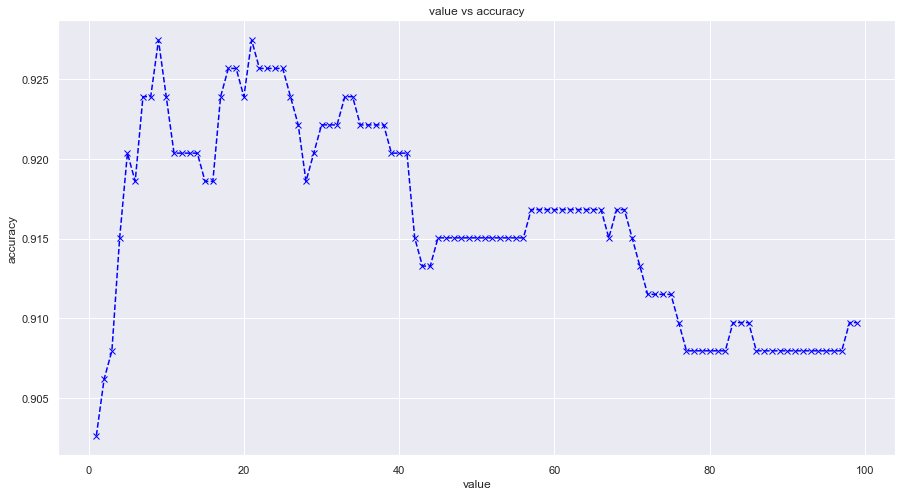

In [109]:
# find the highest parameter

accuracy = []

for i in range(1,100):
  svc = svm.SVC(kernel='rbf', gamma=i)
  svc.fit(X_train, y_train.ravel())
  y_pred = svc.predict(X_test)
  accuracy.append(accuracy_score(y_test, y_pred.ravel()))
plt.plot(list(range(1,100)), accuracy, color='blue', linestyle='dashed', marker='x')
plt.xlabel('value')
plt.ylabel('accuracy')
plt.title('value vs accuracy')
plt.show()

In [110]:
df = pd.DataFrame(accuracy, list(range(1,100)), columns = ['Accruacy'])
df[df['Accruacy'] == df['Accruacy'].max()]

,Accruacy
9,0.927434
21,0.927434


In [111]:
# Retrain the model according to the highest parameter
from sklearn.svm import SVC

model = svm.SVC(kernel='rbf', gamma=df[df['Accruacy'] == df['Accruacy'].max()].index.values[0])
model.fit(X_train, y_train.ravel())

SVC(gamma=9)

#### Testing the model

In [112]:
y_train_pred_svm = model.predict(X_train)
y_test_pred_svm = model.predict(X_test)

# Calculate the accuracy
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, y_train_pred_svm)
test_accuracy = accuracy_score(y_test, y_test_pred_svm)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 0.9468488990129081
The test accuracy is 0.9274336283185841


#### 5-Fold cross validation

In [113]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

k = 5
kf = KFold(n_splits=k)

#for other scoring parameters see here https://scikit-learn.org/stable/modules/model_evaluation.html
result = cross_val_score(model, X_train, y_train.ravel(), cv = kf, scoring='accuracy')
 
print(f' Avg accuracy:{result.mean()}')

 Avg accuracy:0.9240407881092292


#### Stratified 10-Fold Cross Validation

In [114]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=32)
result = cross_val_score(model, X_train, y_train.ravel(), cv = skf, scoring='accuracy')
print(f' Avg accuracy:{result.mean()}')

 Avg accuracy:0.9270992366412214


> the score is less than the full set for train, but it's within the acceptable range of 2~5%  

#### Generating the confusion matrix

In [115]:
confusion_matrix(y_test, y_test_pred_svm)

array([[140,  30],
       [ 11, 384]], dtype=int64)

In [116]:
#Generating the confusion matrix as a dataframe. 
pd.DataFrame(confusion_matrix(y_test, y_test_pred_svm), columns = ['Actual Positive (Up)', 'Acutal Negative (Down)'], index = [ 'Predicted Positive (Up)', 'Predicted Negative (Down)']          )

,Actual Positive (Up),Acutal Negative (Down)
Predicted Positive (Up),140,30
Predicted Negative (Down),11,384


#### Classification Report

In [117]:
#Generate Classification Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred_svm))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       170
           1       0.93      0.97      0.95       395

    accuracy                           0.93       565
   macro avg       0.93      0.90      0.91       565
weighted avg       0.93      0.93      0.93       565



In [118]:
report =  classification_report(y_test, y_test_pred_svm)
lines = report.split('\n')

score = {}
score['model'] = 'Support Vector Machines by RBF'
for i in range(len(lines[5:-1])):
#     print(lines[5:-1][i].split('      '))
    if i == 0:
        score['accuracy'] = float(lines[5:-1][i].split('      ')[4].strip())*100
    elif i == 2:
        score['precision'] = float(lines[5:-1][i].split('      ')[1].strip())*100
        score['recall'] = float(lines[5:-1][i].split('      ')[2].strip())*100
        score['f1-score'] = float(lines[5:-1][i].split('      ')[3].strip())*100
        score['support'] = float(lines[5:-1][i].split('      ')[4].strip())

score_svmr_df = pd.DataFrame([score])
score_svmr_df

,model,accuracy,precision,recall,f1-score,support
0,Support Vector Machines by RBF,93.0,93.0,93.0,93.0,565.0


#### Converting the prediction to a dataframe

In [119]:
#converting the prediction to a dataframe

y_pred_df = pd.DataFrame(y_test_pred_svm, columns = ['predicted price up or down'])

In [120]:
#dataframe of predicted values
y_pred_df.head(2)

,predicted price up or down
0,1
1,1


In [121]:
# creating a merged dataframe of test data and the predictions

df = pd.concat([pd.DataFrame(X_test, columns = features.columns).reset_index(drop=True), y_test.reset_index(drop=True), y_pred_df.reset_index(drop=True)], axis=1)

In [122]:
# We can now compare our predictions with the actual data

df.head()

,Cpi,Jclaim,Int_rate,Stock_price,Inf,Cboe,Gold,Oil,Bitcoin,Dollar,Result,predicted price up or down
0,0.679896,0.677642,-1.773689,0.849355,-0.240178,1.299619,1.714555,-0.991116,0.188251,-0.901483,1,1
1,0.398699,-0.392942,-0.354657,0.183303,-0.658690,-0.487642,0.259255,0.029440,-0.184783,0.968678,1,1
2,-0.309394,-0.361942,0.806427,-0.195908,0.263566,-1.155803,-0.490673,0.359650,0.073058,-1.028698,1,1
3,-0.408370,-0.343206,0.601139,-0.380992,0.041378,-1.216180,-0.546160,-0.119649,-0.364314,-0.552205,1,1
4,-0.524726,-0.330410,0.399333,-0.499776,-0.191390,-1.086348,-0.522742,-0.490787,-0.514079,-0.772879,1,1


### SVM(Support Vector Machines by Polynomial Regression)

#### Training the SVM

In [123]:
from sklearn import svm

model = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train, y_train.ravel())
model.fit(X_train, y_train.ravel())

SVC(C=1, decision_function_shape='ovo', kernel='poly')

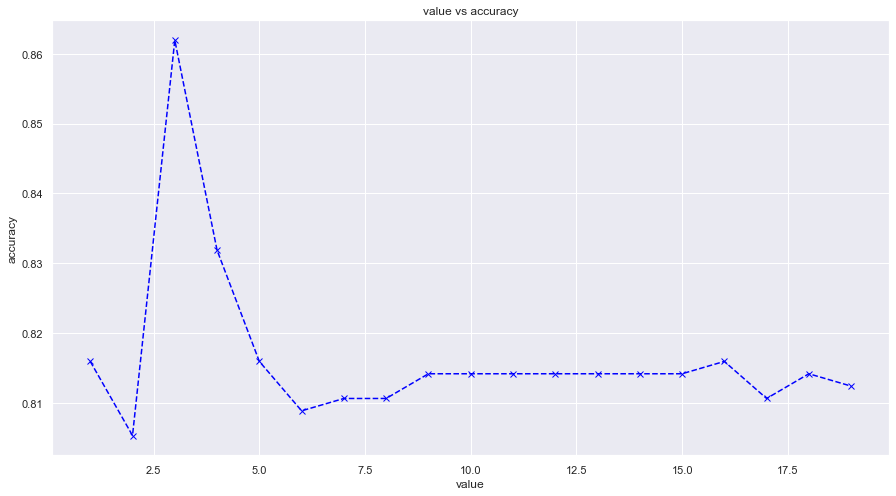

In [124]:
# find the highest parameter

accuracy = []

for i in range(1,20):
  svc = svm.SVC(kernel='poly', degree=i)
  svc.fit(X_train, y_train.ravel())
  y_pred = svc.predict(X_test)
  accuracy.append(accuracy_score(y_test, y_pred.ravel()))
plt.plot(list(range(1,20)), accuracy, color='blue', linestyle='dashed', marker='x')
plt.xlabel('value')
plt.ylabel('accuracy')
plt.title('value vs accuracy')
plt.show()

In [125]:
df = pd.DataFrame(accuracy, list(range(1,20)), columns = ['Accruacy'])
df[df['Accruacy'] == df['Accruacy'].max()]

,Accruacy
3,0.861947


In [126]:
# Retrain the model according to the highest parameter
from sklearn.svm import SVC

model = svm.SVC(kernel='poly', degree=df[df['Accruacy'] == df['Accruacy'].max()].index.values[0], C=1, decision_function_shape='ovo').fit(X_train, y_train.ravel())
model.fit(X_train, y_train.ravel())

SVC(C=1, decision_function_shape='ovo', kernel='poly')

#### Testing the model

In [127]:
y_train_pred_svm = model.predict(X_train)
y_test_pred_svm = model.predict(X_test)

# Calculate the accuracy
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, y_train_pred_svm)
test_accuracy = accuracy_score(y_test, y_test_pred_svm)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 0.8709187547456341
The test accuracy is 0.8619469026548673


#### 5-Fold cross validation

In [128]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

k = 5
kf = KFold(n_splits=k)

#for other scoring parameters see here https://scikit-learn.org/stable/modules/model_evaluation.html
result = cross_val_score(model, X_train, y_train.ravel(), cv = kf, scoring='accuracy')
 
print(f' Avg accuracy:{result.mean()}')

 Avg accuracy:0.8580020739716557


#### Stratified 10-Fold Cross Validation

In [129]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=32)
result = cross_val_score(model, X_train, y_train.ravel(), cv = skf, scoring='accuracy')
print(f' Avg accuracy:{result.mean()}')

 Avg accuracy:0.8648623640990053


> the score is less than the full set for train, but it's within the acceptable range of 2~5%  

#### Generating the confusion matrix

In [130]:
confusion_matrix(y_test, y_test_pred_svm)

array([[100,  70],
       [  8, 387]], dtype=int64)

In [131]:
#Generating the confusion matrix as a dataframe. 
pd.DataFrame(confusion_matrix(y_test, y_test_pred_svm), columns = ['Actual Positive (Up)', 'Acutal Negative (Down)'], index = [ 'Predicted Positive (Up)', 'Predicted Negative (Down)']          )

,Actual Positive (Up),Acutal Negative (Down)
Predicted Positive (Up),100,70
Predicted Negative (Down),8,387


#### Classification Report

In [132]:
#Generate Classification Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred_svm))

              precision    recall  f1-score   support

           0       0.93      0.59      0.72       170
           1       0.85      0.98      0.91       395

    accuracy                           0.86       565
   macro avg       0.89      0.78      0.81       565
weighted avg       0.87      0.86      0.85       565



In [133]:
report =  classification_report(y_test, y_test_pred_svm)
lines = report.split('\n')

score = {}
score['model'] = 'Support Vector Machines by POLY'
for i in range(len(lines[5:-1])):
#     print(lines[5:-1][i].split('      '))
    if i == 0:
        score['accuracy'] = float(lines[5:-1][i].split('      ')[4].strip())*100
    elif i == 2:
        score['precision'] = float(lines[5:-1][i].split('      ')[1].strip())*100
        score['recall'] = float(lines[5:-1][i].split('      ')[2].strip())*100
        score['f1-score'] = float(lines[5:-1][i].split('      ')[3].strip())*100
        score['support'] = float(lines[5:-1][i].split('      ')[4].strip())

score_svmp_df = pd.DataFrame([score])
score_svmp_df

,model,accuracy,precision,recall,f1-score,support
0,Support Vector Machines by POLY,86.0,87.0,86.0,85.0,565.0


#### Converting the prediction to a dataframe

In [134]:
#converting the prediction to a dataframe

y_pred_df = pd.DataFrame(y_test_pred_svm, columns = ['predicted price up or down'])

In [135]:
#dataframe of predicted values
y_pred_df.head(2)

,predicted price up or down
0,1
1,1


In [136]:
# creating a merged dataframe of test data and the predictions

df = pd.concat([pd.DataFrame(X_test, columns = features.columns).reset_index(drop=True), y_test.reset_index(drop=True), y_pred_df.reset_index(drop=True)], axis=1)

In [137]:
# We can now compare our predictions with the actual data

df.head()

,Cpi,Jclaim,Int_rate,Stock_price,Inf,Cboe,Gold,Oil,Bitcoin,Dollar,Result,predicted price up or down
0,0.679896,0.677642,-1.773689,0.849355,-0.240178,1.299619,1.714555,-0.991116,0.188251,-0.901483,1,1
1,0.398699,-0.392942,-0.354657,0.183303,-0.658690,-0.487642,0.259255,0.029440,-0.184783,0.968678,1,1
2,-0.309394,-0.361942,0.806427,-0.195908,0.263566,-1.155803,-0.490673,0.359650,0.073058,-1.028698,1,1
3,-0.408370,-0.343206,0.601139,-0.380992,0.041378,-1.216180,-0.546160,-0.119649,-0.364314,-0.552205,1,1
4,-0.524726,-0.330410,0.399333,-0.499776,-0.191390,-1.086348,-0.522742,-0.490787,-0.514079,-0.772879,1,1


### SVM(Support Vector Machines by Sigmoid)

#### Training the SVM

In [138]:
from sklearn import svm

model = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train, y_train.ravel())
model.fit(X_train, y_train.ravel())

SVC(C=1, decision_function_shape='ovo', kernel='sigmoid')

#### Testing the model

In [139]:
y_train_pred_svm = model.predict(X_train)
y_test_pred_svm = model.predict(X_test)

# Calculate the accuracy
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, y_train_pred_svm)
test_accuracy = accuracy_score(y_test, y_test_pred_svm)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 0.7069096431283219
The test accuracy is 0.6831858407079646


#### 5-Fold cross validation

In [140]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

k = 5
kf = KFold(n_splits=k)

#for other scoring parameters see here https://scikit-learn.org/stable/modules/model_evaluation.html
result = cross_val_score(model, X_train, y_train.ravel(), cv = kf, scoring='accuracy')
 
print(f' Avg accuracy:{result.mean()}')

 Avg accuracy:0.7092118907708261


#### Stratified 10-Fold Cross Validation

In [141]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=32)
result = cross_val_score(model, X_train, y_train.ravel(), cv = skf, scoring='accuracy')
print(f' Avg accuracy:{result.mean()}')

 Avg accuracy:0.7084952579227389


> the score is less than the full set for train, but it's within the acceptable range of 2~5%  

#### Generating the confusion matrix

In [142]:
confusion_matrix(y_test, y_test_pred_svm)

array([[ 65, 105],
       [ 74, 321]], dtype=int64)

In [143]:
#Generating the confusion matrix as a dataframe. 
pd.DataFrame(confusion_matrix(y_test, y_test_pred_svm), columns = ['Actual Positive (Up)', 'Acutal Negative (Down)'], index = [ 'Predicted Positive (Up)', 'Predicted Negative (Down)']          )

,Actual Positive (Up),Acutal Negative (Down)
Predicted Positive (Up),65,105
Predicted Negative (Down),74,321


#### Classification Report

In [144]:
#Generate Classification Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred_svm))

              precision    recall  f1-score   support

           0       0.47      0.38      0.42       170
           1       0.75      0.81      0.78       395

    accuracy                           0.68       565
   macro avg       0.61      0.60      0.60       565
weighted avg       0.67      0.68      0.67       565



In [145]:
report =  classification_report(y_test, y_test_pred_svm)
lines = report.split('\n')

score = {}
score['model'] = 'Support Vector Machines by Sigmoid'
for i in range(len(lines[5:-1])):
#     print(lines[5:-1][i].split('      '))
    if i == 0:
        score['accuracy'] = float(lines[5:-1][i].split('      ')[4].strip())*100
    elif i == 2:
        score['precision'] = float(lines[5:-1][i].split('      ')[1].strip())*100
        score['recall'] = float(lines[5:-1][i].split('      ')[2].strip())*100
        score['f1-score'] = float(lines[5:-1][i].split('      ')[3].strip())*100
        score['support'] = float(lines[5:-1][i].split('      ')[4].strip())

score_svms_df = pd.DataFrame([score])
score_svms_df

,model,accuracy,precision,recall,f1-score,support
0,Support Vector Machines by Sigmoid,68.0,67.0,68.0,67.0,565.0


#### Converting the prediction to a dataframe

In [146]:
#converting the prediction to a dataframe

y_pred_df = pd.DataFrame(y_test_pred_svm, columns = ['predicted price up or down'])

In [147]:
#dataframe of predicted values
y_pred_df.head(2)

,predicted price up or down
0,1
1,1


In [148]:
# creating a merged dataframe of test data and the predictions

df = pd.concat([pd.DataFrame(X_test, columns = features.columns).reset_index(drop=True), y_test.reset_index(drop=True), y_pred_df.reset_index(drop=True)], axis=1)

In [149]:
# We can now compare our predictions with the actual data

df.head()

,Cpi,Jclaim,Int_rate,Stock_price,Inf,Cboe,Gold,Oil,Bitcoin,Dollar,Result,predicted price up or down
0,0.679896,0.677642,-1.773689,0.849355,-0.240178,1.299619,1.714555,-0.991116,0.188251,-0.901483,1,1
1,0.398699,-0.392942,-0.354657,0.183303,-0.658690,-0.487642,0.259255,0.029440,-0.184783,0.968678,1,1
2,-0.309394,-0.361942,0.806427,-0.195908,0.263566,-1.155803,-0.490673,0.359650,0.073058,-1.028698,1,1
3,-0.408370,-0.343206,0.601139,-0.380992,0.041378,-1.216180,-0.546160,-0.119649,-0.364314,-0.552205,1,1
4,-0.524726,-0.330410,0.399333,-0.499776,-0.191390,-1.086348,-0.522742,-0.490787,-0.514079,-0.772879,1,1


## Classification_Metrics_Graph

In [150]:
frames = [score_lr_df, score_dt_df, score_rf_df, score_mnb_df, score_gnb_df, 
          score_knn_df, score_svml_df, score_svmr_df, score_svmp_df, score_svms_df]
score = pd.concat(frames).reset_index(drop = True)
score

,model,accuracy,precision,recall,f1-score,support
0,Logistic Regression,83.0,83.0,83.0,82.0,565.0
1,Decision Tree,96.0,96.0,96.0,96.0,565.0
2,Random Forest,96.0,96.0,96.0,96.0,565.0
3,Multinomial Naive Bayes,39.0,55.0,39.0,39.0,565.0
4,Guassian Naive Bayes,78.0,79.0,78.0,75.0,565.0
5,K-Nearest Neighbors,95.0,96.0,95.0,95.0,565.0
6,Support Vector Machines by Linear,83.0,83.0,83.0,82.0,565.0
7,Support Vector Machines by RBF,93.0,93.0,93.0,93.0,565.0
8,Support Vector Machines by POLY,86.0,87.0,86.0,85.0,565.0
9,Support Vector Machines by Sigmoid,68.0,67.0,68.0,67.0,565.0


In [151]:
score.reset_index(drop = True).sort_values('accuracy', ascending = False).reset_index(drop = True)

,model,accuracy,precision,recall,f1-score,support
0,Decision Tree,96.0,96.0,96.0,96.0,565.0
1,Random Forest,96.0,96.0,96.0,96.0,565.0
2,K-Nearest Neighbors,95.0,96.0,95.0,95.0,565.0
3,Support Vector Machines by RBF,93.0,93.0,93.0,93.0,565.0
4,Support Vector Machines by POLY,86.0,87.0,86.0,85.0,565.0
5,Logistic Regression,83.0,83.0,83.0,82.0,565.0
6,Support Vector Machines by Linear,83.0,83.0,83.0,82.0,565.0
7,Guassian Naive Bayes,78.0,79.0,78.0,75.0,565.0
8,Support Vector Machines by Sigmoid,68.0,67.0,68.0,67.0,565.0
9,Multinomial Naive Bayes,39.0,55.0,39.0,39.0,565.0


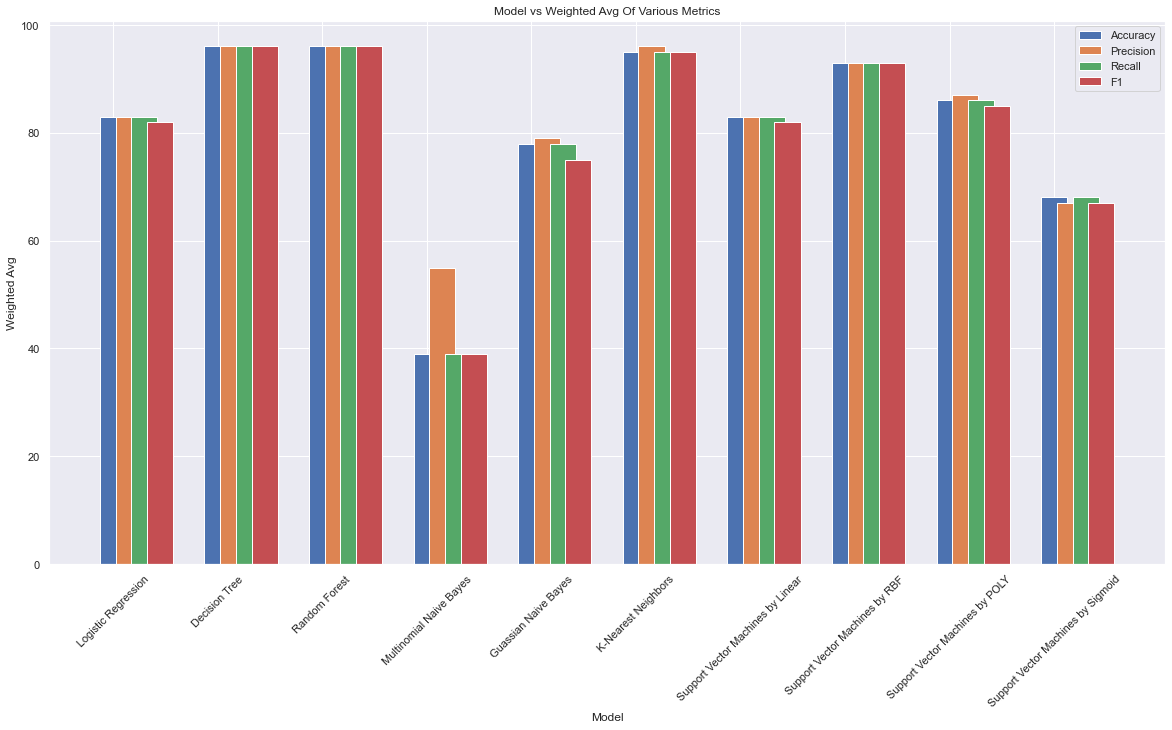

In [152]:
import numpy as np 
import matplotlib.pyplot as plt 
  
# for SVM, the highest values from the kernel, poly
X   = score.model.tolist()

#Collect this information from the classification reports and store them in lists
accuracy  = score.accuracy.tolist()
precision = score.precision.tolist()
recall    = score.recall.tolist()
f1        = score['f1-score'].tolist()


#here we use np.arange to get the number of items to place on the x-axis 
X_axis = np.arange(len(X))

#the spacing between each bar each bar
spacing= 0.15

#setting the size of the graph
plt.rcParams["figure.figsize"] = (20,10)
  
#below we are plotting 4 bars for each label on the x-axis with the following syntax
#plt.bar(star_pos_for_each_bar, list_of_values, width_of each_bar, label_name_for each bar)
plt.bar(X_axis, accuracy, 0.25, label = 'Accuracy')
plt.bar(X_axis + spacing, precision, 0.25, label = 'Precision')
plt.bar(X_axis + spacing *2, recall, 0.25, label = 'Recall')
plt.bar(X_axis + spacing *3, f1, 0.25, label = 'F1')

#setting the range of values for the X axis
plt.xticks(X_axis, X)
plt.xlabel("Model")
plt.ylabel("Weighted Avg")
plt.xticks(rotation = 45)
plt.title("Model vs Weighted Avg Of Various Metrics")
plt.legend(loc='upper right')

plt.show()

# Additionl Research: multi-linear regression

In [153]:
df_stats = df.copy()
df_stats['intercept'] = 1

import statsmodels.api as sm
lm = sm.OLS(df_stats['Stock_price'], df_stats[['intercept','Cpi', 'Jclaim', 'Int_rate', 'Inf', 'Cboe', 'Gold', 'Oil', 'Bitcoin', 'Dollar']]) # exclude 'Bitcoin' due to high pvalue
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Stock_price   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     7843.
Date:                Mon, 23 May 2022   Prob (F-statistic):               0.00
Time:                        19:29:24   Log-Likelihood:                 554.31
No. Observations:                 565   AIC:                            -1089.
Df Residuals:                     555   BIC:                            -1045.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.004      0.215      0.830      -0.007       0.009
Cpi            0.9590      0.023     41.465      0.000       0.914       1.004
Jclaim         0.0133      0.008      1.689      0.092      -0.002       0.029
Int_rate      -0.2402      0.019    -12.562      0.000      -0.278      -0.203
Inf            0.2296      0.017     13.312      0.000       0.196       0.264
Cboe          -0.0780      0.007    -10.800      0.000      -0.092      -0.064
Gold          -0.2129      0.028     -7.610      0.000      -0.268      -0.158
Oil           -0.1400      0.011    -12.473      0.000      -0.162      -0.118
Bitcoin        0.0724      0.016      4.494      0.000       0.041       0.104
Dollar        -0.1160      0.006    -18.630      0.000      -0.128      -0.104
==============================================================================
Omnibus:                        4.550   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.103   Jarque-Bera (JB):                4.581
Skew:                          -0.219   Prob(JB):                        0.101
Kurtosis:                       2.953   Cond. No.                         23.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [154]:
# Remove the variable having possible multicollinearity: Jclaim

lm = sm.OLS(df_stats['Stock_price'], df_stats[['intercept', 'Cpi', 'Int_rate', 'Inf', 'Cboe', 'Gold', 'Oil', 'Bitcoin', 'Dollar']]) # exclude 'Bitcoin' due to high pvalue
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Stock_price   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     8794.
Date:                Mon, 23 May 2022   Prob (F-statistic):               0.00
Time:                        19:29:24   Log-Likelihood:                 552.86
No. Observations:                 565   AIC:                            -1088.
Df Residuals:                     556   BIC:                            -1049.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   9.531e-05      0.004      0.024      0.980      -0.008       0.008
Cpi            0.9562      0.023     41.381      0.000       0.911       1.002
Int_rate      -0.2373      0.019    -12.441      0.000      -0.275      -0.200
Inf            0.2280      0.017     13.215      0.000       0.194       0.262
Cboe          -0.0717      0.006    -11.590      0.000      -0.084      -0.060
Gold          -0.2061      0.028     -7.432      0.000      -0.261      -0.152
Oil           -0.1445      0.011    -13.235      0.000      -0.166      -0.123
Bitcoin        0.0738      0.016      4.580      0.000       0.042       0.105
Dollar        -0.1155      0.006    -18.543      0.000      -0.128      -0.103
==============================================================================
Omnibus:                        5.408   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                5.505
Skew:                          -0.237   Prob(JB):                       0.0638
Kurtosis:                       2.908   Cond. No.                         23.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We got the `R-squared of 99.2%` and extremely low P-values, meaning features are significantly correlated when we set the stock price(S&P 500) as the outcome and the other variable except the variable 'Result' as the features. This is worth predicting the stock price by replacing the outcome, the S&P 500 indexes, with the target stock after finding the correlation coefficient between S&P 500 and the stock ticker. 

# Reference

- *Useful moving average("How to Use a Moving Average to Buy Stocks", Investopedia, Cory Mitchell, Apr 28 2021): https://www.investopedia.com/articles/active-trading/052014/how-use-moving-average-buy-stocks.asp)*

- *Most important moving average("Why the 50-Day Simple Moving Average Is Popular Among Traders", Investopedia, J.B. MAVERICK: https://www.investopedia.com/ask/answers/012815/why-50-simple-moving-average-sma-so-common-traders-and-analysts.asp)*

- *Decision classifer by sklearn(https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)*